# Correlation and regression

Elements of Data Science

by [Allen Downey](https://allendowney.com)

[MIT License](https://opensource.org/licenses/MIT)


In this example, we use height and weight from the BRFSS to compute correlation and simple regression, show the relationship between $\rho$ and $R^2$, and demonstrate that:

* Correlation has no natural interpretation, and generally overstates the strength of a relationship between variables.

* Coefficient of determination has an interpretation, but still overstates the predictive value of the relationship.

* If we compute a more meaningful measure of predictive value, like reduction in mean absolute error (MAE) it is generally less impressive than $\rho$ and $R^2$ suggest.

Let's get some data.

In [1]:
# Get the data file

import os

if not os.path.exists('brfss.hdf5'):
    !wget https://github.com/AllenDowney/ElementsOfDataScience/raw/master/brfss.hdf5

And import the libraries.

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

## BRFSS

Here's a subset of the BRFSS data I extracted and resampled.

In [3]:
brfss = pd.read_hdf('brfss.hdf5', 'brfss')
brfss.shape

(100000, 9)

I'll select the rows that have valid height and weight data.

In [4]:
subset = brfss.dropna(subset=['WTKG3', 'HTM4'])

height = subset['HTM4']
weight = subset['WTKG3']

Before plotting, I'll jitter the data to avoid artifacts due to rounding.

In [5]:
height_jitter = height + np.random.normal(0, 2, size=len(subset))
weight_jitter = weight + np.random.normal(0, 2, size=len(subset))

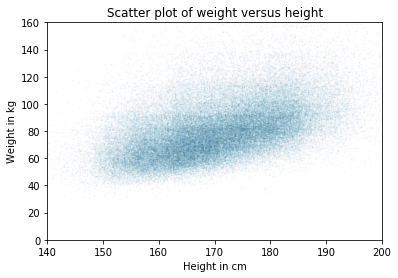

In [6]:
plt.plot(height_jitter, weight_jitter, 'o', alpha=0.02, markersize=1)

plt.xlim([140, 200])
plt.ylim([0, 160])
plt.xlabel('Height in cm')
plt.ylabel('Weight in kg')
plt.title('Scatter plot of weight versus height');

Not surprisingly, taller people tend to be heavier.  The coefficient of correlation quantifies the strength of this relationship.

In [7]:
corr_matrix = np.corrcoef(height, weight)
corr_matrix

array([[1.        , 0.47420309],
       [0.47420309, 1.        ]])

$\rho$ is about 0.47, which sounds like a strong correlation, but we'll see that it is not as impressive as it sounds.

## Regression

Now we can compute the linear regression.

In [8]:
from scipy.stats import linregress

result = linregress(height, weight)
result

LinregressResult(slope=0.9192115381848297, intercept=-75.12704250330233, rvalue=0.47420308979024584, pvalue=0.0, stderr=0.005632863769802998)

The slope is 0.9, which suggests that if someone is 1 cm taller, we expect them to be 0.9 kg heavier.

We can use the regression equation to generate a predicted weight for each height.

In [10]:
predictions = result.intercept + result.slope * height

And I'll plot the predictions on top of the scatter plot.

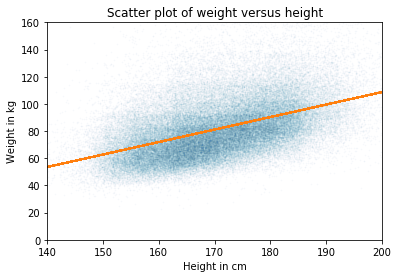

In [11]:
plt.plot(height_jitter, weight_jitter, 'o', alpha=0.02, markersize=1)

plt.plot(height, predictions, '-')

plt.xlim([140, 200])
plt.ylim([0, 160])
plt.xlabel('Height in cm')
plt.ylabel('Weight in kg')
plt.title('Scatter plot of weight versus height');

It looks like the predictions are consistent with the trend of the data.

The result of the linear regression also includes `rvalue`, which turns out to the same as the correlation we computed earlier.

In [12]:
rho = result.rvalue
rho, corr_matrix[0][1]

(0.47420308979024584, 0.4742030897902459)

## Residuals

A residual is the difference between the actual values and the predictions.

In [13]:
residuals = weight - predictions

The mean of the residuals should be close to 0.

In [ ]:
residuals.mean()

The variance of the residuals is a measure of how spread out they are.

In [ ]:
var_res = residuals.var()
var_res

By itself, that doesn't mean much, but we can compare it to the variance of the original data. 

In [ ]:
var_y = weight.var()
var_y

The variance of the residuals is smaller than the variance of the original data.

In [ ]:
var_res / var_y

The variance of the residuals is about 77% of the variance in the data.

The coefficient of determination is the complement of this fraction:

In [ ]:
r_squared = 1 - var_res / var_y
r_squared

Instead of doing this calculation ourselves, we could have computed $R^2 = \rho^2$:

In [ ]:
rho**2

For this regression model, $R^2$ is about 0.22, which means that height "explains" 22% of the variance in weight.

At least, that's the language statisticians use to describe $R^2$, but it's not always clear what "explains" means.

I think it is more meaningful to quantify the predictive value of the model by comparing some measurement of error with and without the model.

## Prediction error

Suppose we choose a random person in the population and try to guess their weight.  If we know nothing about them, it might be sensible to use the mean of the population as a guess.

In [ ]:
guess1 = weight.mean()
guess1

If we do that, how much do we expect to be off by, on average?  To answer that, we can compute the [mean absolute error](https://en.wikipedia.org/wiki/Mean_absolute_error) (MAE).

In [14]:
error1 = weight - guess1
MAE1 = error1.abs().mean()
MAE1

NameError: name 'guess1' is not defined

If we always guess 81.3 kg, we'll be off by about 16 kg on average.

Now suppose we know the person's height, and we uses the regression model to guess their weight.  How much better could we do?

Here are the errors.

In [ ]:
guess2 = predictions
error2 = weight - guess2

And here's the mean absolute error using height information.

In [ ]:
MAE2 = error2.abs().mean()
MAE2

We expect to be off by about 13.8 kg on average.

Compared to the error without the model, we're reduced MAE by about 14%.

In [ ]:
MAE2 / MAE1

In [ ]:
1 - MAE2 / MAE1

In summary:

* The correlation of height and weight is about 0.47, which might sound like a strong correlation, but it has no natural interpretation in terms of predictive value.

* The coefficient of determination is about 0.22, which means that the regression model "explains" 22% of the variance in weight.  But the word "explain" is being used in a technical sense that doesn't always means what it sounds like.  And $R^2$ still doesn't quantify the predictive value of the model.

* Using height to predict weight reduces mean absolute error by about 14%, so the model has some predictive value, but it is more modest than the values of $\rho$ and $R^2$ might lead you to expect.

This dataset is not unusual.  $R^2$ is generally less than $\rho$, and both of them generally overstate the predictive value of the model.